In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [35]:
class Gauss:
    """Gaussian function"""
    def __init__(self, x0=None, fwhm=None, ampl=None):
        self.x0_init = x0
        self.fwhm_init = fwhm
        self.amplitude_init = ampl
        self.param_name = [('x0', 'fwhm', 'amplitude'), ]
        
    def __call__(self, x, x0, fwhm, amplitude):
        sigma = fwhm /( 2*np.sqrt(2*np.log(2)) )
        return amplitude * np.exp( -(x-x0)**2/(2*sigma**2) )
    
    def estimate_param(self, x, y):
        if not self.x0_init:
            self.x0_init = x[np.argmax(y)]
        if not self.fwhm_init:
            self.fwhm_init = np.ptp( x[ y - y.min() > y.max()/2 ] )
        if not self.amplitude_init:
            self.amplitude_init = np.ptp(y)
 
        return self.x0_init, self.fwhm_init, self.amplitude_init

In [36]:
class Linear:
    """Linear function"""
    def __init__(self, slope=None, intercept=None):
        self.slope_init = slope
        self.intercept_init = intercept
        self.param_name = [('slope', 'intercept'), ]
        
    def __call__(self, x, slope, intercept):
        return x*slope + intercept
    
    def estimate_param(self, x, y):
        if not self.slope_init:
            self.slope_init = (y[-1] - y[0])/(x[-1] - x[0])
        if not self.intercept_init:
            self.intercept_init = y[0] - self.slope_init*x[0]
 
        return self.slope_init, self.intercept_init

In [37]:
x = np.linspace(-5, 5, 123)

gauss = Gauss()
y = gauss(x, 0, 1, 1)
y += .1 *np.random.rand(*y.shape)

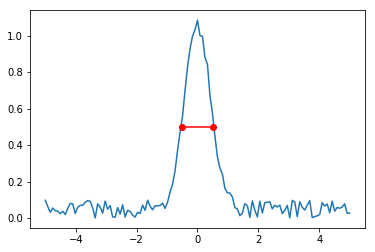

In [38]:
plt.plot(x, y);
plt.plot([-.5, .5], [.5, .5], '-or');

In [39]:
class Sum:
    """Build a new function as the sum of two function"""
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
        self.param_name = a.param_name + b.param_name
        
    def __call__(self, x, *p):
        nargs_a = sum(len(u) for u in self.a.param_name)
        p_a = p[:nargs_a]
        p_b = p[nargs_a:]
        return self.a(x, *p_a) + self.b(x, *p_b)
    
    def estimate_param(self, x, y):
        p_a = self.a.estimate_param(x, y)
        p_b = self.b.estimate_param(x, y)
        return (*p_a, *p_b)

In [40]:
def flatten(t):
    """Unpack nested list or tuple
    i.e. keep only one level of nesting
    note: only check the first level
    >>> flatten([['a', 'b'], [['c', 'd'], ('e', 'f')]])
    [['a', 'b'], ['c', 'd'], ('e', 'f')]
    """
    out = []
    for el in t:
        if isinstance(el[0], list) or isinstance(el[0], tuple):
            out.extend(el)
        else:
            out.append(el)
    return out

In [41]:
s = Sum(Sum(Gauss(), Gauss()), Linear())

In [42]:
s.estimate_param(x, y)

(0.0,
 0.9836065573770485,
 1.0837285123076221,
 0.0,
 0.9836065573770485,
 1.0837285123076221,
 -0.007045109171479713,
 0.06157200752164292)

In [43]:
from scipy.optimize import curve_fit

In [98]:
def peakfit(x, y, function=Gauss(), background=Linear()):

    p0_fun = function.estimate_param(x, y)
    p0_bg = background.estimate_param(x, y)
    p0 = p0_fun + p0_bg

    nargs = len(p0_fun)

    def f(x, *p):
        return function(x, *p[:nargs]) + background(x, *p[nargs:])

    popt, pcov = curve_fit(f, x, y, p0)

    result = []
    idx = 0
    for names in function.param_name:
        res = {}
        for name in names:
            res[name] = popt[idx]
            idx += 1

        result.append(res)
    
    return result, lambda x:f(x, *popt)


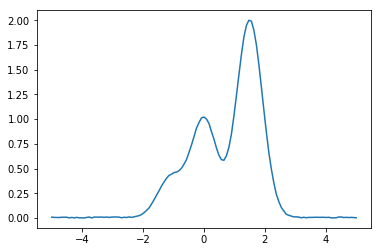

In [99]:
x = np.linspace(-5, 5, 123)

gauss = Gauss()
y = gauss(x, 0, 1, 1)
y += .01 *np.random.rand(*y.shape)
y += gauss(x, 1.5, 1, 2)
y += gauss(x, -1.1, 1, .4)

plt.plot(x, y);

In [110]:
s = Sum(Sum(Gauss(.01), Gauss(-.1)), Gauss(1))

In [127]:
s = Sum(Gauss(), Gauss(.1))

In [128]:
minimizer, fit = peakfit(x, y, s)

In [129]:
minimizer

[{'amplitude': 1.9212697254610471,
  'fwhm': 0.9180780238113186,
  'x0': 1.5411405897171553},
 {'amplitude': 0.8752667610431127,
  'fwhm': 1.8018520324254925,
  'x0': -0.09948879872747039}]

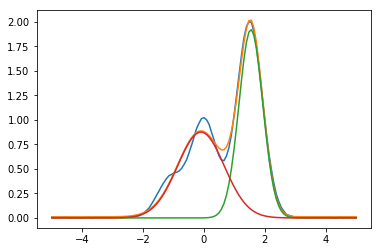

In [130]:
plt.plot(x, y);
plt.plot(x, fit(x))
plt.plot(x, Gauss()(x, **minimizer[0]))
plt.plot(x, Gauss()(x, **minimizer[1]))

In [145]:
s = Sum(Gauss(1), Gauss(13))

In [33]:
Gauss().param_name

('x0', 'fwhm', 'amplitude')

In [148]:
ss = Sum(s, Gauss(2))

In [149]:
ss.estimate_param(x, y)

(1,
 0.9836065573770485,
 1.0975978674968836,
 1,
 0.9836065573770485,
 1.0975978674968836,
 1,
 0.9836065573770485,
 1.0975978674968836,
 1,
 0.9836065573770485,
 1.0975978674968836)